In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import linear_model
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [86]:
dataset = pd.read_csv("ADNI_ALL.csv")

In [87]:
observation = dataset[(dataset.DX == 'Dementia') & (dataset.VISCODE == 'bl') & (dataset.DX_bl != 'AD')]
dataset = dataset.drop(observation.index)
dataset.loc[dataset.DX == 'Dementia', 'DX'] = 'AD'

dataset.loc[dataset['DX_bl'].isin(['EMCI', 'LMCI']), 'DX_bl'] = 'MCI'
dataset.loc[dataset['DX_bl'] == 'SMC', 'DX_bl'] = 'CN'

observation_AD_MCI = dataset[(dataset['DX_bl'] == 'AD') & (dataset['DX'] == 'MCI') & (dataset.VISCODE == 'bl')]
observation_MCI_CN = dataset[(dataset['DX_bl'] == 'MCI') & (dataset['DX'] == 'CN') & (dataset.VISCODE == 'bl')]
observation = pd.concat([observation_AD_MCI, observation_MCI_CN, observation])

dataset = dataset.drop(observation_AD_MCI.index)
dataset = dataset.drop(observation_MCI_CN.index)

In [88]:
adni1 = dataset[dataset['ORIGPROT'] == 'ADNI1'].copy()
adni2 = dataset[dataset['ORIGPROT'] == 'ADNI2'].copy()
adni3 = dataset[dataset['ORIGPROT'] == 'ADNI3'].copy()
adnigo = dataset[dataset['ORIGPROT'] == 'ADNIGO'].copy()

In [89]:
df = adni1[adni1['M'] == 0] 

protein_features = ['TAU', 'ABETA', 'PTAU']

for i in protein_features:
    all = df[i].values
    df = df.drop(i, axis=1)
    df[i] = [float(str(x).replace('<','').replace('>','')) for x in all]

drop_features1 = ['DX_bl', 'M', 'VISCODE', 'update_stamp', 'Month']
drop_features2 = ['RID', 'PTID', 'SITE', 'ORIGPROT', 'COLPROT', 'FSVERSION', 'IMAGEUID', 'FLDSTRENG', 'EXAMDATE']

baseline_features = []
nulls = dict(df.isna().sum().sort_values())
null_columns = []


for i in df.columns.values:
    if '_bl' in i or '_BL' in i:
        baseline_features.append(i)
    elif nulls[i] > df.shape[0]/1.1:
        baseline_features.append(i)
        
df = df.drop(drop_features1 + drop_features2 + baseline_features + null_columns, axis=1)

In [90]:
df['PTGENDER'] = (df['PTGENDER'] == 'Female')*1

categorical_features = ['PTETHCAT', 'PTRACCAT', 'PTMARRY']
dummy_featues = pd.get_dummies(df[categorical_features])
df = pd.concat([df, dummy_featues], axis=1)

df = df.rename(index=str, columns={"PTGENDER": "PTGENDER_Female"})
df = df.drop(categorical_features, axis=1)
df = df.dropna(subset=['DX'])
df['DX'] = df['DX'].map({'CN': 1, 'MCI': 2, 'AD': 3})

In [91]:
# Imputation

blank_df = pd.DataFrame(df.isna().sum().sort_values(), columns=['Nulls'])
new_blank_values = blank_df[blank_df['Nulls'] > 0].to_dict()['Nulls']
blank_values = new_blank_values.keys()
not_empty_values = df.columns.difference(blank_values).values
dict1 = {}

random_value = -247
df = df.fillna(random_value)

for i, column in enumerate(blank_values):
    
    train = df[df[column] != random_value]
    x = train[train.columns.difference([column, 'DX'])]
    y = train[column]    
   
    test = df[df[column] == random_value]
    x_tes = test[test.columns.difference([column, 'DX'])]
    y_tes = test[column]   
    
    model = KNeighborsRegressor(n_neighbors=5).fit(x, y)
    
    index1 = df[df[column] == random_value][column].index.values
    dict1[column] = model.predict(x_tes)
    
for column in blank_values:
    index1 = df[df[column] == random_value][column].index.values
    df.loc[index1, column] = dict1[column]

In [92]:
df.columns

Index(['AGE', 'PTGENDER_Female', 'PTEDUCAT', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX', 'mPACCdigit', 'mPACCtrailsB', 'TAU', 'ABETA', 'PTAU', 'PTETHCAT_Hisp/Latino', 'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 'PTRACCAT_Am Indian/Alaskan',
       'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_More than one', 'PTRACCAT_White', 'PTMARRY_Divorced', 'PTMARRY_Married', 'PTMARRY_Never married', 'PTMARRY_Unknown', 'PTMARRY_Widowed'],
      dtype='object')

In [94]:
X = df[df.columns.difference(['DX'])]
Y = df['DX']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state= 42)

In [95]:
X_train2 = X_train[['MMSE', 'ADAS11', 'ADAS13', 'ADASQ4', 'RAVLT_immediate', 'RAVLT_learning', 'DIGITSCOR', 'mPACCdigit', 'mPACCtrailsB', 'LDELTOTAL']]
X_test2 = X_test[['MMSE', 'ADAS11', 'ADAS13', 'ADASQ4', 'RAVLT_immediate', 'RAVLT_learning', 'DIGITSCOR', 'mPACCdigit', 'mPACCtrailsB', 'LDELTOTAL']]

In [18]:
def model_evaluation(X_train2, y_train, model):
    model.fit(X_train2, y_train)
    preds = model.predict(X_test2)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train2, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    difference = scores.mean() - model.score(X_test2, y_test)
    Standard_deviation = difference / scores.std()
    Hamming_Loss = metrics.hamming_loss(y_test, preds)
    Jaccard_Index = metrics.jaccard_score(y_test, preds, average='micro')
    Accuracy = metrics.accuracy_score(y_test, preds)
    MCC = matthews_corrcoef(y_test, preds)

    print(f"Training Score:{model.score(X_train2, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test2, y_test)}")
    print(f"Cross & Test Diff: {difference}")
    print(f"Standard Deviation: {Standard_deviation}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    print(f"Hamming Loss: {Hamming_Loss}")
    print(f"Jaccard Score: {Jaccard_Index}")
    print(f"MCC: {MCC}")
    print(f"Accuracy: {Accuracy}")
    print("Overall Accuracy:",accuracy_score(y_test, preds))
    print("Balanced Accuracy:",balanced_accuracy_score(y_test, preds))
    print("Overall Precision:",precision_score(y_test, preds, average='weighted'))
    print("Overall Recall:",recall_score(y_test, preds, average='weighted'))
    print("Overall Precision, Recall, F-measure:",precision_recall_fscore_support(y_test, preds, average='weighted'))

In [19]:
def plot_model(model):
    predict = model.predict_proba(X_test2)
    classes = ['CN', 'MCI', 'AD']  
    fpr = {}
    tpr = {}
    thresh ={}
    for i in range(len(classes)):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, predict[:,i], pos_label=i)
        
    auc = roc_auc_score(y_test,predict, multi_class='ovr')
    print('Average AUC:', auc)
    log_loss = metrics.log_loss(y_test, predict)
    print(f"Log loss: {log_loss}")    

    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=classes[0] + ' vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=classes[1] + ' vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=classes[2] + ' vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()

Training Score:0.7614678899082569
Cross V Score: 0.7492307692307694 +/- 0.06037048231962559
Testing Score: 0.7560975609756098
Cross & Test Diff: -0.006866791744840395
Standard Deviation: -0.11374419221110145
[[56  3  0]
 [10 43 23]
 [ 0  4 25]]
              precision    recall  f1-score   support

           1       0.85      0.95      0.90        59
           2       0.86      0.57      0.68        76
           3       0.52      0.86      0.65        29

    accuracy                           0.76       164
   macro avg       0.74      0.79      0.74       164
weighted avg       0.80      0.76      0.75       164

Hamming Loss: 0.24390243902439024
Jaccard Score: 0.6078431372549019
MCC: 0.6517722920627922
Accuracy: 0.7560975609756098
Overall Accuracy: 0.7560975609756098
Balanced Accuracy: 0.7923369938581111
Overall Precision: 0.7958827605321508
Overall Recall: 0.7560975609756098
Overall Precision, Recall, F-measure: (0.7958827605321508, 0.7560975609756098, 0.7534645408791751, None)


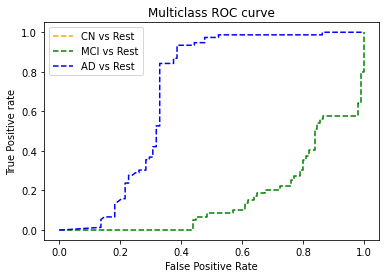

In [20]:
#AdaBoost

clf1 = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, algorithm='SAMME.R', random_state=0)
model_evaluation(X_train2, y_train, clf1)
plot_model(clf1)

Training Score:0.9923547400611621
Cross V Score: 0.8438927738927741 +/- 0.04808002014935583
Testing Score: 0.8841463414634146
Cross & Test Diff: -0.04025356757064058
Standard Deviation: -0.837220272487342
[[55  4  0]
 [ 0 68  8]
 [ 0  7 22]]
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        59
           2       0.86      0.89      0.88        76
           3       0.73      0.76      0.75        29

    accuracy                           0.88       164
   macro avg       0.86      0.86      0.86       164
weighted avg       0.89      0.88      0.89       164

Hamming Loss: 0.11585365853658537
Jaccard Score: 0.7923497267759563
MCC: 0.8149026543049386
Accuracy: 0.8841463414634146
Overall Accuracy: 0.8841463414634146
Balanced Accuracy: 0.8618536405303147
Overall Precision: 0.888319440156427
Overall Recall: 0.8841463414634146
Overall Precision, Recall, F-measure: (0.888319440156427, 0.8841463414634146, 0.8856147205683734, None)
Avera

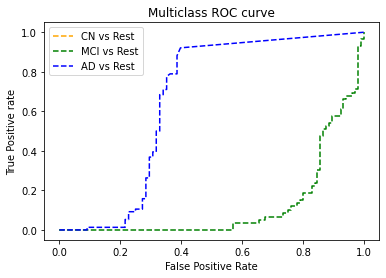

In [21]:
#ExtraTrees

clf2 = ExtraTreesClassifier(n_estimators=100, criterion='gini', 
                             max_depth=None, min_samples_split=2, min_samples_leaf=2, 
                             min_weight_fraction_leaf=0.0, max_features='auto',
                             max_leaf_nodes=None, min_impurity_decrease=0.0, 
                            bootstrap=False, oob_score=False, 
                             n_jobs=4, random_state=None, verbose=0, warm_start=False, 
                             class_weight=None, ccp_alpha=0.0, max_samples=None)
model_evaluation(X_train2, y_train, clf2)
plot_model(clf2)

Training Score:1.0
Cross V Score: 0.8556332556332558 +/- 0.04332029846310665
Testing Score: 0.8963414634146342
Cross & Test Diff: -0.0407082077813784
Standard Deviation: -0.9397028466008189
[[55  4  0]
 [ 0 68  8]
 [ 0  5 24]]
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        59
           2       0.88      0.89      0.89        76
           3       0.75      0.83      0.79        29

    accuracy                           0.90       164
   macro avg       0.88      0.88      0.88       164
weighted avg       0.90      0.90      0.90       164

Hamming Loss: 0.10365853658536585
Jaccard Score: 0.8121546961325967
MCC: 0.8353950171398566
Accuracy: 0.8963414634146342
Overall Accuracy: 0.8963414634146342
Balanced Accuracy: 0.8848421462774411
Overall Precision: 0.9016273360785556
Overall Recall: 0.8963414634146342
Overall Precision, Recall, F-measure: (0.9016273360785556, 0.8963414634146342, 0.8982015380982111, None)
Average AUC: 0.962

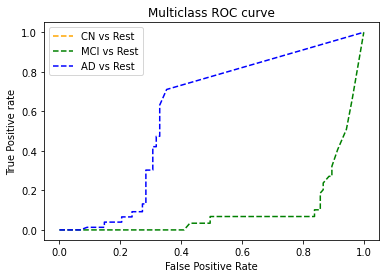

In [22]:
#RandomForest

clf3 = RandomForestClassifier(n_estimators=100, criterion='gini', 
                               max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0,  
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                               verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
model_evaluation(X_train2, y_train, clf3)
plot_model(clf3)

[01:28:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score:0.9587155963302753
Cross V Score: 0.8454856254856257 +/- 0.041122639681018744
Testing Score: 0.8963414634146342
Cross & Test Diff: -0.050855837929008496
Standard Deviation: -1.236687097994888
[[55  4  0]
 [ 0 68  8]
 [ 0  5 24]]
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        59
           2       0.88      0.89      0.89        76
           3       0.75      0.83      0.79        29

    accuracy                           0.90       164
   macro avg       0.88      0.88      0.88       164
weighted avg       0.90      0.90      0.90       164

Hamming Loss: 0.10365853658536585
Jaccard Score: 0.8121546961325

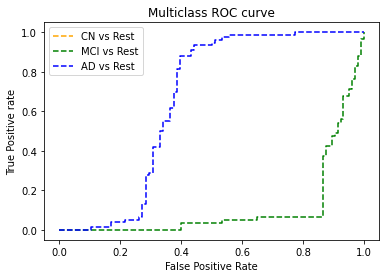

In [23]:
#XGB

clf4 = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, objective='multi:softprob', num_class= 10,
                  n_estimators=100, max_depth=3)
model_evaluation(X_train2, y_train, clf4)
plot_model(clf4)

Training Score:0.9128440366972477
Cross V Score: 0.8388733488733491 +/- 0.034700458890991485
Testing Score: 0.8597560975609756
Cross & Test Diff: -0.020882748687626518
Standard Deviation: -0.6018003610046738
[[55  4  0]
 [ 0 66 10]
 [ 0  9 20]]
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        59
           2       0.84      0.87      0.85        76
           3       0.67      0.69      0.68        29

    accuracy                           0.86       164
   macro avg       0.83      0.83      0.83       164
weighted avg       0.86      0.86      0.86       164

Hamming Loss: 0.1402439024390244
Jaccard Score: 0.7540106951871658
MCC: 0.7757711016203591
Accuracy: 0.8597560975609756
Overall Accuracy: 0.8597560975609756
Balanced Accuracy: 0.8300932049586268
Overall Precision: 0.8647988062159102
Overall Recall: 0.8597560975609756
Overall Precision, Recall, F-measure: (0.8647988062159102, 0.8597560975609756, 0.8616672082665692, None)
A

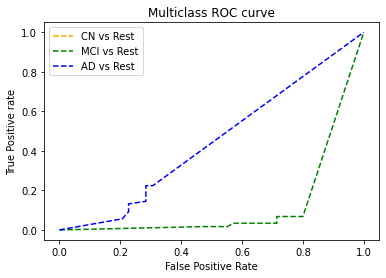

In [24]:
#DT

clf5 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=8, min_samples_split=8, min_samples_leaf=8, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
model_evaluation(X_train2, y_train, clf5)
plot_model(clf5)

Training Score:0.8532110091743119
Cross V Score: 0.8311888111888114 +/- 0.037230196351258404
Testing Score: 0.8719512195121951
Cross & Test Diff: -0.040762408323383736
Standard Deviation: -1.0948749219262697
[[54  5  0]
 [ 2 68  6]
 [ 0  8 21]]
              precision    recall  f1-score   support

           1       0.96      0.92      0.94        59
           2       0.84      0.89      0.87        76
           3       0.78      0.72      0.75        29

    accuracy                           0.87       164
   macro avg       0.86      0.84      0.85       164
weighted avg       0.87      0.87      0.87       164

Hamming Loss: 0.12804878048780488
Jaccard Score: 0.772972972972973
MCC: 0.7941350273928638
Accuracy: 0.8719512195121951
Overall Accuracy: 0.8719512195121951
Balanced Accuracy: 0.8447096701426271
Overall Precision: 0.8734809867939951
Overall Recall: 0.8719512195121951
Overall Precision, Recall, F-measure: (0.8734809867939951, 0.8719512195121951, 0.8719090887599544, None)
A

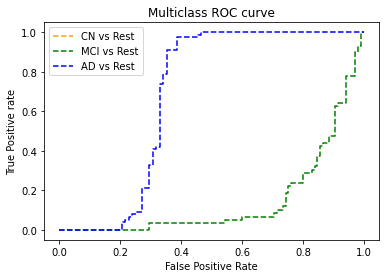

In [25]:
#LassoLogisticRegression

clf6 = linear_model.LogisticRegression(penalty='l1',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
model_evaluation(X_train2, y_train, clf6)
plot_model(clf6)

Training Score:0.8623853211009175
Cross V Score: 0.8485392385392386 +/- 0.03642647347756179
Testing Score: 0.8902439024390244
Cross & Test Diff: -0.04170466389978578
Standard Deviation: -1.1448998466863745
[[55  4  0]
 [ 0 68  8]
 [ 0  6 23]]
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        59
           2       0.87      0.89      0.88        76
           3       0.74      0.79      0.77        29

    accuracy                           0.89       164
   macro avg       0.87      0.87      0.87       164
weighted avg       0.89      0.89      0.89       164

Hamming Loss: 0.10975609756097561
Jaccard Score: 0.8021978021978022
MCC: 0.8251251968710196
Accuracy: 0.8902439024390244
Overall Accuracy: 0.8902439024390244
Balanced Accuracy: 0.8733478934038779
Overall Precision: 0.8949545078577337
Overall Recall: 0.8902439024390244
Overall Precision, Recall, F-measure: (0.8949545078577337, 0.8902439024390244, 0.8919514695830486, None)
Av

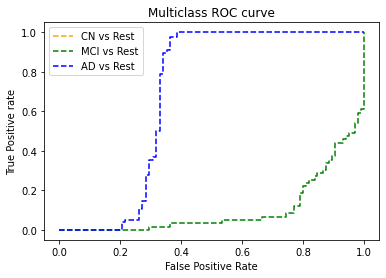

In [26]:
#RidgeLogisticRegression

clf7 = linear_model.LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, 
                                       fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                       random_state=None, solver='saga', max_iter=100, multi_class='auto', 
                                       verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
model_evaluation(X_train2, y_train, clf7)
plot_model(clf7)

In [28]:
#PassiveAgrressive

clf8 = PassiveAggressiveClassifier(random_state=0, max_iter=1000)
model_evaluation(X_train2, y_train, clf8)

Training Score:0.7767584097859327
Cross V Score: 0.7852836052836055 +/- 0.050013074483142274
Testing Score: 0.774390243902439
Cross & Test Diff: 0.010893361381166478
Standard Deviation: 0.21781027248861223
[[34 25  0]
 [ 0 73  3]
 [ 0  9 20]]
              precision    recall  f1-score   support

           1       1.00      0.58      0.73        59
           2       0.68      0.96      0.80        76
           3       0.87      0.69      0.77        29

    accuracy                           0.77       164
   macro avg       0.85      0.74      0.77       164
weighted avg       0.83      0.77      0.77       164

Hamming Loss: 0.22560975609756098
Jaccard Score: 0.6318407960199005
MCC: 0.659216645793122
Accuracy: 0.774390243902439
Overall Accuracy: 0.774390243902439
Balanced Accuracy: 0.7421508915479816
Overall Precision: 0.8296820645979722
Overall Recall: 0.774390243902439
Overall Precision, Recall, F-measure: (0.8296820645979722, 0.774390243902439, 0.7687887624106684, None)


Average AUC: 0.956725963241723
Log loss: 0.5138879179190633


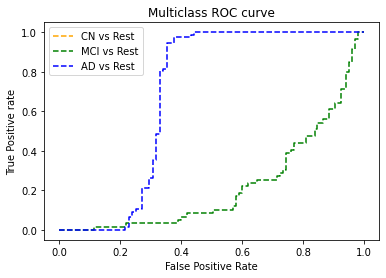

In [31]:
predict = clf8._predict_proba_lr(X_test2)

classes = ['CN', 'MCI', 'AD']

fpr = {}
tpr = {}
thresh ={}
for i in range(len(classes)):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, predict[:,i], pos_label=i)
    
auc = roc_auc_score(y_test,predict, multi_class='ovr')
print('Average AUC:', auc)
log_loss = metrics.log_loss(y_test, predict)
print(f"Log loss: {log_loss}")

plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=classes[0] + ' vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=classes[1] + ' vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=classes[2] + ' vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

Training Score:0.8287461773700305
Cross V Score: 0.7741181041181042 +/- 0.04483879484967383
Testing Score: 0.8841463414634146
Cross & Test Diff: -0.11002823734531042
Standard Deviation: -2.45386250264286
[[55  4  0]
 [ 2 71  3]
 [ 0 10 19]]
              precision    recall  f1-score   support

           1       0.96      0.93      0.95        59
           2       0.84      0.93      0.88        76
           3       0.86      0.66      0.75        29

    accuracy                           0.88       164
   macro avg       0.89      0.84      0.86       164
weighted avg       0.89      0.88      0.88       164

Hamming Loss: 0.11585365853658537
Jaccard Score: 0.7923497267759563
MCC: 0.8140028383081698
Accuracy: 0.8841463414634146
Overall Accuracy: 0.8841463414634146
Balanced Accuracy: 0.8405287766464671
Overall Precision: 0.8869367807806984
Overall Recall: 0.8841463414634146
Overall Precision, Recall, F-measure: (0.8869367807806984, 0.8841463414634146, 0.881629115243567, None)
Avera

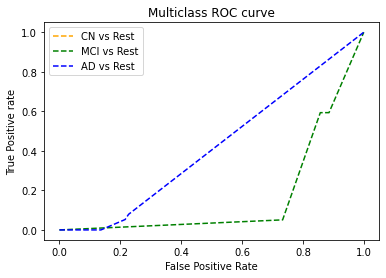

In [32]:
#SGD

clf9 = linear_model.SGDClassifier(loss='modified_huber', penalty='l1', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
model_evaluation(X_train2, y_train, clf9)
plot_model(clf9)

Training Score:0.6987767584097859
Cross V Score: 0.6986402486402489 +/- 0.0488207494866197
Testing Score: 0.6524390243902439
Cross & Test Diff: 0.046201224250004946
Standard Deviation: 0.9463440183905271
[[31 28  0]
 [ 0 61 15]
 [ 0 14 15]]
              precision    recall  f1-score   support

           1       1.00      0.53      0.69        59
           2       0.59      0.80      0.68        76
           3       0.50      0.52      0.51        29

    accuracy                           0.65       164
   macro avg       0.70      0.62      0.63       164
weighted avg       0.72      0.65      0.65       164

Hamming Loss: 0.3475609756097561
Jaccard Score: 0.4841628959276018
MCC: 0.45102147470582366
Accuracy: 0.6524390243902439
Overall Accuracy: 0.6524390243902439
Balanced Accuracy: 0.6150988956904242
Overall Precision: 0.7226201752308785
Overall Recall: 0.652439024390244
Overall Precision, Recall, F-measure: (0.7226201752308785, 0.652439024390244, 0.6535920112065434, None)
Averag

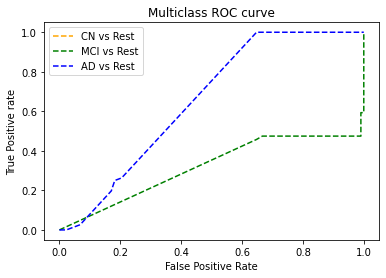

In [33]:
#BernoulliNB

clf10 = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
model_evaluation(X_train2, y_train, clf10)
plot_model(clf10)

Training Score:0.8027522935779816
Cross V Score: 0.7991608391608392 +/- 0.04864802795564566
Testing Score: 0.8170731707317073
Cross & Test Diff: -0.017912331570868023
Standard Deviation: -0.3682026245174708
[[56  3  0]
 [ 9 55 12]
 [ 0  6 23]]
              precision    recall  f1-score   support

           1       0.86      0.95      0.90        59
           2       0.86      0.72      0.79        76
           3       0.66      0.79      0.72        29

    accuracy                           0.82       164
   macro avg       0.79      0.82      0.80       164
weighted avg       0.82      0.82      0.82       164

Hamming Loss: 0.18292682926829268
Jaccard Score: 0.6907216494845361
MCC: 0.7182618235086985
Accuracy: 0.8170731707317073
Overall Accuracy: 0.8170731707317073
Balanced Accuracy: 0.8219800670583531
Overall Precision: 0.8243927566336103
Overall Recall: 0.8170731707317073
Overall Precision, Recall, F-measure: (0.8243927566336103, 0.8170731707317073, 0.8161485261886029, None)
A

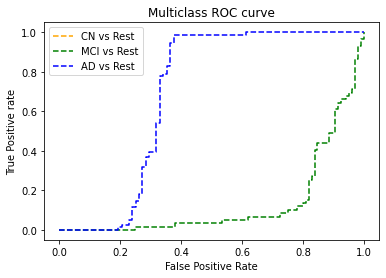

In [34]:
#GaussianNB

clf11 = GaussianNB()
model_evaluation(X_train2, y_train, clf11)
plot_model(clf11)

Training Score:0.8486238532110092
Cross V Score: 0.8082672882672884 +/- 0.042472104857884996
Testing Score: 0.8536585365853658
Cross & Test Diff: -0.04539124831807739
Standard Deviation: -1.0687308403941853
[[56  3  0]
 [ 5 62  9]
 [ 0  7 22]]
              precision    recall  f1-score   support

           1       0.92      0.95      0.93        59
           2       0.86      0.82      0.84        76
           3       0.71      0.76      0.73        29

    accuracy                           0.85       164
   macro avg       0.83      0.84      0.83       164
weighted avg       0.85      0.85      0.85       164

Hamming Loss: 0.14634146341463414
Jaccard Score: 0.7446808510638298
MCC: 0.7680209001202505
Accuracy: 0.8536585365853658
Overall Accuracy: 0.8536585365853658
Balanced Accuracy: 0.8411875685707547
Overall Precision: 0.8548111221461238
Overall Recall: 0.8536585365853658
Overall Precision, Recall, F-measure: (0.8548111221461238, 0.8536585365853658, 0.853713469567128, None)
Av

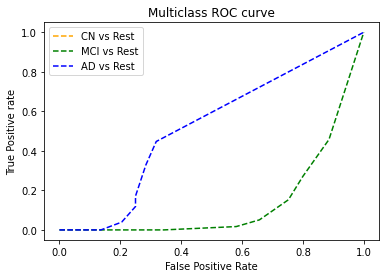

In [35]:
#KNN

clf12 = KNeighborsClassifier(n_neighbors=7, weights='uniform', 
                             algorithm='auto', leaf_size=1, p=1, 
                             metric='minkowski', metric_params=None, n_jobs=None)
model_evaluation(X_train2, y_train, clf12)
plot_model(clf12)

In [119]:
#LinearSVM

clf13 = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, tol=0.0001, 
                 C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, 
                 class_weight='balanced', verbose=0, random_state=None, max_iter=1000)
model_evaluation(X_train2, y_train, clf13)

Training Score:0.8318042813455657
Cross V Score: 0.8093550893550894 +/- 0.03975976371503785
Testing Score: 0.8597560975609756
Cross & Test Diff: -0.05040100820588622
Standard Deviation: -1.2676385243915236
[[55  4  0]
 [ 4 62 10]
 [ 1  4 24]]
              precision    recall  f1-score   support

           1       0.92      0.93      0.92        59
           2       0.89      0.82      0.85        76
           3       0.71      0.83      0.76        29

    accuracy                           0.86       164
   macro avg       0.84      0.86      0.85       164
weighted avg       0.87      0.86      0.86       164

Hamming Loss: 0.1402439024390244
Jaccard Score: 0.7540106951871658
MCC: 0.7802526369831759
Accuracy: 0.8597560975609756
Overall Accuracy: 0.8597560975609756
Balanced Accuracy: 0.8585263568037568
Overall Precision: 0.8650500444080071
Overall Recall: 0.8597560975609756
Overall Precision, Recall, F-measure: (0.8650500444080071, 0.8597560975609756, 0.8608597465046827, None)


Average AUC: 0.9653982120455508
Log loss: 0.5269038385629065


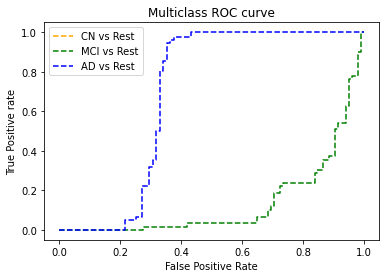

In [37]:
predict = clf13._predict_proba_lr(X_test2)

classes = ['CN', 'MCI', 'AD']

fpr = {}
tpr = {}
thresh ={}
for i in range(len(classes)):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, predict[:,i], pos_label=i)
    
auc = roc_auc_score(y_test,predict, multi_class='ovr')
print('Average AUC:', auc)
log_loss = metrics.log_loss(y_test, predict)
print(f"Log loss: {log_loss}")

plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=classes[0] + ' vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=classes[1] + ' vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=classes[2] + ' vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

Training Score:0.8333333333333334
Cross V Score: 0.8174281274281276 +/- 0.05126254073063913
Testing Score: 0.8963414634146342
Cross & Test Diff: -0.07891333598650652
Standard Deviation: -1.539395723695388
[[56  3  0]
 [ 1 69  6]
 [ 0  7 22]]
              precision    recall  f1-score   support

           1       0.98      0.95      0.97        59
           2       0.87      0.91      0.89        76
           3       0.79      0.76      0.77        29

    accuracy                           0.90       164
   macro avg       0.88      0.87      0.88       164
weighted avg       0.90      0.90      0.90       164

Hamming Loss: 0.10365853658536585
Jaccard Score: 0.8121546961325967
MCC: 0.8335842703429751
Accuracy: 0.8963414634146342
Overall Accuracy: 0.8963414634146342
Balanced Accuracy: 0.8718893229567198
Overall Precision: 0.8971364231820677
Overall Recall: 0.8963414634146342
Overall Precision, Recall, F-measure: (0.8971364231820677, 0.8963414634146342, 0.8964390139188555, None)
Ave

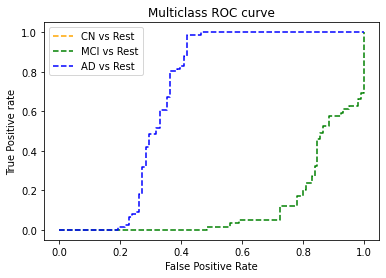

In [38]:
#RBFSVM

clf14 = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
model_evaluation(X_train2, y_train, clf14)
plot_model(clf14)

In [41]:
#Perceptron

clf15 = Perceptron(random_state=0, max_iter=1000, penalty='l1', alpha=0.0001, shuffle=True, tol=1e-3)
model_evaluation(X_train2, y_train, clf15)

Training Score:0.8149847094801224
Cross V Score: 0.7680652680652682 +/- 0.0614972725993543
Testing Score: 0.8109756097560976
Cross & Test Diff: -0.04291034169082941
Standard Deviation: -0.6977600774327666
[[42 17  0]
 [ 0 71  5]
 [ 0  9 20]]
              precision    recall  f1-score   support

           1       1.00      0.71      0.83        59
           2       0.73      0.93      0.82        76
           3       0.80      0.69      0.74        29

    accuracy                           0.81       164
   macro avg       0.84      0.78      0.80       164
weighted avg       0.84      0.81      0.81       164

Hamming Loss: 0.18902439024390244
Jaccard Score: 0.6820512820512821
MCC: 0.7056053774015386
Accuracy: 0.8109756097560976
Overall Accuracy: 0.8109756097560976
Balanced Accuracy: 0.7785767018364146
Overall Precision: 0.8404199145084232
Overall Recall: 0.8109756097560976
Overall Precision, Recall, F-measure: (0.8404199145084232, 0.8109756097560976, 0.8105627518435852, None)


Iteration 1, loss = 5.60861345
Iteration 2, loss = 3.07858919
Iteration 3, loss = 1.92976823
Iteration 4, loss = 1.28174511
Iteration 5, loss = 0.93033942
Iteration 6, loss = 0.78697276
Iteration 7, loss = 0.74191755
Iteration 8, loss = 0.71616970
Iteration 9, loss = 0.69364532
Iteration 10, loss = 0.65471764
Iteration 11, loss = 0.63024823
Iteration 12, loss = 0.62882225
Iteration 13, loss = 0.62109668
Iteration 14, loss = 0.59427900
Iteration 15, loss = 0.57632787
Iteration 16, loss = 0.56135841
Iteration 17, loss = 0.54708471
Iteration 18, loss = 0.53038883
Iteration 19, loss = 0.52041005
Iteration 20, loss = 0.50335685
Iteration 21, loss = 0.49793347
Iteration 22, loss = 0.47928714
Iteration 23, loss = 0.46255555
Iteration 24, loss = 0.44866146
Iteration 25, loss = 0.43308842
Iteration 26, loss = 0.42712828
Iteration 27, loss = 0.42101023
Iteration 28, loss = 0.41671018
Iteration 29, loss = 0.41103212
Iteration 30, loss = 0.42474588
Iteration 31, loss = 0.38392047
Iteration 32, los

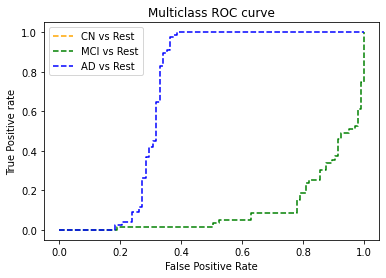

In [44]:
# MLPClassifier 

clf16 = MLPClassifier(solver='adam', alpha=1e-5, 
                      hidden_layer_sizes=(15,), random_state=1)
model_evaluation(X_train2, y_train, clf16)
plot_model(clf16)

Training Score:0.8899082568807339
Cross V Score: 0.8434809634809636 +/- 0.0417389919320622
Testing Score: 0.8963414634146342
Cross & Test Diff: -0.05286049993367059
Standard Deviation: -1.2664536800436068
[[55  4  0]
 [ 0 71  5]
 [ 0  8 21]]
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        59
           2       0.86      0.93      0.89        76
           3       0.81      0.72      0.76        29

    accuracy                           0.90       164
   macro avg       0.89      0.86      0.87       164
weighted avg       0.90      0.90      0.90       164

Hamming Loss: 0.10365853658536585
Jaccard Score: 0.8121546961325967
MCC: 0.8338886225319949
Accuracy: 0.8963414634146342
Overall Accuracy: 0.8963414634146342
Balanced Accuracy: 0.8635172823935936
Overall Precision: 0.8989946653405367
Overall Recall: 0.8963414634146342
Overall Precision, Recall, F-measure: (0.8989946653405367, 0.8963414634146342, 0.8960334935569272, None)
Ave

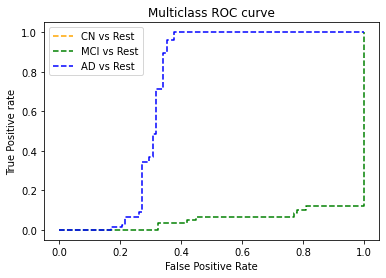

In [45]:
clf16 = MLPClassifier(solver='lbfgs', alpha=1e-5, activation='tanh', 
                      hidden_layer_sizes=(15,), random_state=1)
model_evaluation(X_train2, y_train, clf16)
plot_model(clf16)

In [46]:
import numpy as np
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.layers import Dense, RNN, LSTM, Activation, Dropout
import tensorflow as tf
from tensorflow import keras

tf.config.run_functions_eagerly(True)

In [47]:
X_train_new2 = np.resize(X_train2,(X_train2.shape[0],1,X_train2.shape[1]))
X_test_new2 = np.resize(X_test2,(X_test2.shape[0],1,X_test2.shape[1]))

In [49]:
import keras.backend as K

def precision(y_test, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_test, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [52]:
#LSTM

model=Sequential()
model.add(LSTM(128,input_shape=(1,10),activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy', precision, recall])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            71168     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [53]:
model.fit(X_train_new2,y_train,epochs=120,batch_size=64)
results = model.evaluate(X_test_new2,y_test)
print(results)

Epoch 1/120
11/11 [==============================] - 3s 57ms/step - loss: 1.3040 - accuracy: 0.3810 - precision: 1062684336.0000 - recall: 1.9500
Epoch 2/120
11/11 [==============================] - 1s 61ms/step - loss: 0.8203 - accuracy: 0.6398 - precision: 3.8669 - recall: 1.6194
Epoch 3/120
11/11 [==============================] - 1s 57ms/step - loss: 0.6332 - accuracy: 0.7261 - precision: 1.3967 - recall: 1.3420
Epoch 4/120
11/11 [==============================] - 1s 62ms/step - loss: 0.6172 - accuracy: 0.7001 - precision: 1.3740 - recall: 1.3233
Epoch 5/120
11/11 [==============================] - 1s 83ms/step - loss: 0.5679 - accuracy: 0.7542 - precision: 1.4040 - recall: 1.3444
Epoch 6/120
11/11 [==============================] - 1s 58ms/step - loss: 0.5049 - accuracy: 0.7666 - precision: 1.3498 - recall: 1.2971
Epoch 7/120
11/11 [==============================] - 1s 54ms/step - loss: 0.4787 - accuracy: 0.7761 - precision: 1.3214 - recall: 1.3015
Epoch 8/120
11/11 [=============

In [54]:
p = model.predict(X_test_new2)
print(p)

[[1.38983523e-04 3.80092679e-04 6.28255963e-01 3.71224999e-01]
 [1.33277965e-04 2.73280889e-01 7.23448753e-01 3.13709956e-03]
 [2.45724495e-05 4.71656680e-01 5.27988791e-01 3.29912087e-04]
 [7.57061613e-08 3.06759011e-06 9.53959107e-01 4.60377149e-02]
 [1.26657440e-04 2.73031276e-03 9.09177005e-01 8.79660249e-02]
 [1.88005200e-04 1.08760782e-02 9.49846447e-01 3.90894525e-02]
 [2.74703939e-06 8.63673722e-06 1.81639344e-01 8.18349302e-01]
 [5.16287400e-07 2.44518305e-05 9.55899298e-01 4.40757163e-02]
 [1.03617667e-15 1.00000000e+00 3.46359430e-09 6.93712994e-18]
 [5.61292145e-05 1.47396844e-04 6.05887234e-01 3.93909216e-01]
 [6.16924123e-10 1.48182244e-05 9.99558508e-01 4.26729675e-04]
 [4.04512044e-03 1.12203630e-02 6.89303458e-01 2.95431107e-01]
 [4.96594504e-38 1.00000000e+00 4.07093690e-23 0.00000000e+00]
 [8.97671634e-05 2.47226184e-04 7.15321958e-01 2.84341007e-01]
 [1.98991856e-05 4.85773891e-01 5.14009893e-01 1.96238238e-04]
 [1.62262097e-07 2.97412015e-07 4.54258025e-02 9.545737

In [56]:
scores = model.evaluate(X_test_new2, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 89.02%


In [60]:
pred = model.predict(X_test_new2)
pred_y = pred.argmax(axis=-1)
cm = confusion_matrix(y_test, pred_y)

In [61]:
print(cm)

[[51  8  0]
 [ 0 70  6]
 [ 0  6 23]]


In [62]:
print("Balanced Accuracy:",balanced_accuracy_score(y_test, pred_y))
print("Overall Precision:",precision_score(y_test, pred_y, average='weighted'))
print("Overall Recall:",recall_score(y_test, pred_y, average='weighted'))
print("Overall Precision, Recall, F-measure:",precision_recall_fscore_support(y_test, pred_y, average='weighted'))

Balanced Accuracy: 0.8595209531719421
Overall Precision: 0.8861788617886179
Overall Recall: 0.8780487804878049
Overall Precision, Recall, F-measure: (0.8861788617886179, 0.8780487804878049, 0.8793237250554324, None)


In [71]:
#GRU

from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed, Input

model = Sequential(name="GRU-Model") 
model.add(Input(shape=(X_train_new2.shape[1],X_train_new2.shape[2]), name='Input-Layer')) 
model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer'))
model.add(RepeatVector(X_train.shape[1], name='Repeat-Vector-Layer'))
model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
model.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) 

model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], 
              loss_weights=None, 
              weighted_metrics=None, 
              run_eagerly=None, 
              steps_per_execution=None 
             )

In [72]:
history = model.fit(X_train_new2,
                    y_train,
                    batch_size=1, 
                    epochs=50,
                    verbose=1, 
                    callbacks=None, 
                    validation_split=0.2, 
                    shuffle=True, 
                    class_weight=None,
                    sample_weight=None, 
                    initial_epoch=0, 
                    steps_per_epoch=None, 
                    validation_steps=None, 
                    validation_batch_size=None, 
                    validation_freq=10,
                    max_queue_size=10, 
                    workers=1, 
                    use_multiprocessing=True, 
                   )

Epoch 1/50
523/523 [==============================] - 180s 343ms/step - loss: 0.3293 - mean_squared_error: 0.3293 - mean_absolute_error: 0.4409
Epoch 2/50
523/523 [==============================] - 193s 369ms/step - loss: 0.1737 - mean_squared_error: 0.1737 - mean_absolute_error: 0.3388
Epoch 3/50
523/523 [==============================] - 180s 344ms/step - loss: 0.1734 - mean_squared_error: 0.1734 - mean_absolute_error: 0.3373
Epoch 4/50
523/523 [==============================] - 179s 343ms/step - loss: 0.1517 - mean_squared_error: 0.1517 - mean_absolute_error: 0.3048
Epoch 5/50
523/523 [==============================] - 180s 344ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - mean_absolute_error: 0.2836
Epoch 6/50
523/523 [==============================] - 180s 345ms/step - loss: 0.1398 - mean_squared_error: 0.1398 - mean_absolute_error: 0.2953
Epoch 7/50
523/523 [==============================] - 187s 358ms/step - loss: 0.1228 - mean_squared_error: 0.1228 - mean_absolute_error:

In [75]:
pred_test = model.predict(X_test_new2)
print("")
print('-------------------- Model Summary --------------------')
model.summary() 
print("")
print('-------------------- Weights and Biases --------------------')
print("")
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")
print('-------------------- Evaluation on Test Data --------------------')
results = model.evaluate(X_test_new2, y_test)
print("")


-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden-GRU-Encoder-Layer (Bi (None, 64)                8448      
_________________________________________________________________
Repeat-Vector-Layer (RepeatV (None, 43, 64)            0         
_________________________________________________________________
Hidden-GRU-Decoder-Layer (Bi (None, 43, 64)            18816     
_________________________________________________________________
Output-Layer (TimeDistribute (None, 43, 1)             65        
Total params: 27,329
Trainable params: 27,329
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Too many parameters to print but you can use the code provided if needed

-------------------- Evaluation on Training Data ---------

In [76]:
pred_test = model.predict(X_test_new2)

test_acc = model.evaluate(X_test_new2, y_test)
print('Test accuracy:', test_acc)

scores = model.evaluate(X_test_new2, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

6/6 [==============================] - 1s 164ms/step - loss: 0.1150 - mean_squared_error: 0.1150 - mean_absolute_error: 0.2180
Test accuracy: [0.11500171571969986, 0.11500171571969986, 0.21803320944309235]
Accuracy: 11.50%


In [82]:
#AnotherOneforGRU

model = Sequential(name="GRU-Model") 
model.add(Input(shape=(X_train_new2.shape[1],X_train_new2.shape[2]), name='Input-Layer'))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'tanh'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "GRU-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 128)               53760     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 53,889
Trainable params: 53,889
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
model.fit(X_train_new2, y_train, epochs=50)
test_loss, test_acc = model.evaluate(X_test_new2, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
21/21 [==============================] - 2s 35ms/step - loss: 3.6182 - accuracy: 0.1548
Epoch 2/50
21/21 [==============================] - 1s 32ms/step - loss: -12.3539 - accuracy: 0.2491
Epoch 3/50
21/21 [==============================] - 1s 35ms/step - loss: -15.0782 - accuracy: 0.2460
Epoch 4/50
21/21 [==============================] - 1s 35ms/step - loss: -15.3040 - accuracy: 0.2696
Epoch 5/50
21/21 [==============================] - 1s 27ms/step - loss: -14.6630 - accuracy: 0.2775
Epoch 6/50
21/21 [==============================] - 1s 27ms/step - loss: -14.6227 - accuracy: 0.2648
Epoch 7/50
21/21 [==============================] - 1s 26ms/step - loss: -15.2038 - accuracy: 0.2508
Epoch 8/50
21/21 [==============================] - 1s 27ms/step - loss: -15.1966 - accuracy: 0.2692
Epoch 9/50
21/21 [==============================] - 1s 29ms/step - loss: -14.8871 - accuracy: 0.2720
Epoch 10/50
21/21 [==============================] - 1s 26ms/step - loss: -15.5443 - accuracy

In [96]:
#CNN

X_train2_new = X_train2.values.reshape(X_train2.shape[0],X_train2.shape[1],1)
X_test2_new = X_test2.values.reshape(X_test2.shape[0],X_test2.shape[1],1)

In [97]:
X = X.values.reshape(X.shape[0], X.shape[1], 1)
print(X.shape)

from numpy import unique
print(unique(y))
print(unique(y).sum())

(818, 43, 1)
[  8.     9.23   9.35   9.74   9.75   9.89  10.41  10.57  10.89  11.58
  11.86  11.9   11.99  12.15  12.17  12.23  12.46  12.5   12.57  12.8
  12.91  12.95  13.1   13.11  13.18  13.21  13.29  13.39  13.45  13.46
  13.56  13.99  14.12  14.22  14.25  14.3   14.38  14.57  14.58  14.62
  14.64  14.88  14.99  15.06  15.07  15.13  15.29  15.43  15.45  15.47
  15.51  15.55  15.57  15.74  15.79  15.82  15.88  15.97  16.04  16.07
  16.11  16.13  16.23  16.31  16.32  16.68  16.69  16.71  16.74  16.76
  16.77  16.84  16.98  17.01  17.22  17.58  17.65  17.77  17.86  17.92
  18.02  18.05  18.06  18.07  18.23  18.33  18.34  18.52  18.54  18.56
  18.57  18.62  18.66  18.7   18.85  19.07  19.13  19.33  19.43  19.47
  19.67  19.69  19.71  19.72  19.86  19.88  20.13  20.29  20.33  20.37
  20.62  20.65  20.69  20.72  20.76  20.77  20.8   20.83  20.87  21.19
  21.22  21.39  21.4   21.41  21.45  21.53  21.69  21.84  21.85  22.08
  22.09  22.1   22.19  22.48  22.49  22.5   22.55  22.57  22.75  

In [98]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from keras.models import Sequential
from keras.initializers import Constant

In [99]:
model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(10,1)))
model.add(Dense(16, activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(4, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "adam",               
              metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 9, 64)             192       
_________________________________________________________________
dense_5 (Dense)              (None, 9, 16)             1040      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 260       
Total params: 1,492
Trainable params: 1,492
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.fit(X_train2_new, y_train, batch_size=16,epochs=100, verbose=0)

acc = model.evaluate(X_train2_new, y_train)
print("Loss:", acc[0], "Accuracy:", acc[1])

21/21 [==============================] - 0s 12ms/step - loss: 0.4205 - accuracy: 0.7997
Loss: 0.4205090403556824 Accuracy: 0.7996941804885864


In [101]:
pred = model.predict(X_test2_new)
pred_y = pred.argmax(axis=-1)

cm = confusion_matrix(y_test, pred_y)
print(cm)

[[54  5  0]
 [ 3 58 15]
 [ 0  4 25]]


In [102]:
test_loss, test_acc = model.evaluate(X_test2_new, y_test)
print('Test accuracy:', test_acc)

6/6 [==============================] - 0s 13ms/step - loss: 0.3943 - accuracy: 0.8354
Test accuracy: 0.8353658318519592


In [103]:
print("Balanced Accuracy:",balanced_accuracy_score(y_test, pred_y))
print("Overall Precision:",precision_score(y_test, pred_y, average='weighted'))
print("Overall Recall:",recall_score(y_test, pred_y, average='weighted'))
print("Overall Precision, Recall, F-measure:",precision_recall_fscore_support(y_test, pred_y, average='weighted'))

Balanced Accuracy: 0.8468270325140731
Overall Precision: 0.8525047659647845
Overall Recall: 0.8353658536585366
Overall Precision, Recall, F-measure: (0.8525047659647845, 0.8353658536585366, 0.8389992493093381, None)


In [104]:
model.fit(X_train2_new, y_train, epochs = 120, batch_size=100)

p = model.predict(X_test2_new)
print(p)

Epoch 1/120
7/7 [==============================] - 0s 31ms/step - loss: 0.3924 - accuracy: 0.8104
Epoch 2/120
7/7 [==============================] - 0s 27ms/step - loss: 0.3790 - accuracy: 0.8257
Epoch 3/120
7/7 [==============================] - 0s 32ms/step - loss: 0.3735 - accuracy: 0.8242
Epoch 4/120
7/7 [==============================] - 0s 33ms/step - loss: 0.3726 - accuracy: 0.8287
Epoch 5/120
7/7 [==============================] - 0s 36ms/step - loss: 0.3683 - accuracy: 0.8257
Epoch 6/120
7/7 [==============================] - 0s 37ms/step - loss: 0.3691 - accuracy: 0.8257
Epoch 7/120
7/7 [==============================] - 0s 38ms/step - loss: 0.3689 - accuracy: 0.8272
Epoch 8/120
7/7 [==============================] - 0s 32ms/step - loss: 0.3679 - accuracy: 0.8257
Epoch 9/120
7/7 [==============================] - 0s 44ms/step - loss: 0.3703 - accuracy: 0.8226
Epoch 10/120
7/7 [==============================] - 0s 40ms/step - loss: 0.3687 - accuracy: 0.8287
Epoch 11/120
7/7 [=

In [105]:
test_loss, test_acc = model.evaluate(X_test2_new, y_test)
print('Test accuracy:', test_acc)

6/6 [==============================] - 0s 15ms/step - loss: 0.3332 - accuracy: 0.8720
Test accuracy: 0.8719512224197388


In [106]:
print("Balanced Accuracy:",balanced_accuracy_score(y_test, pred_y))
print("Overall Precision:",precision_score(y_test, pred_y, average='weighted'))
print("Overall Recall:",recall_score(y_test, pred_y, average='weighted'))
print("Overall Precision, Recall, F-measure:",precision_recall_fscore_support(y_test, pred_y, average='weighted'))

Balanced Accuracy: 0.8468270325140731
Overall Precision: 0.8525047659647845
Overall Recall: 0.8353658536585366
Overall Precision, Recall, F-measure: (0.8525047659647845, 0.8353658536585366, 0.8389992493093381, None)


In [115]:
from sklearn.ensemble import StackingClassifier

estimators = []

#Defining 5 Logistic Regression Models
model11 = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
                             random_state=None, solver='sag', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimators.append(('logistic1', model11))
model12 = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
                             random_state=None, solver='sag', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimators.append(('logistic2', model12))
model13 = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
                             random_state=None, solver='sag', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimators.append(('logistic3', model13))
model14 = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
                             random_state=None, solver='sag', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimators.append(('logistic4', model14))
model15 = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
                             random_state=None, solver='sag', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimators.append(('logistic5', model15))

#Defining 3 Decision Tree Classifiers
model16 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=8, min_samples_split=5, min_samples_leaf=5, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=6, min_samples_split=5, min_samples_leaf=5, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=6, min_samples_split=5, min_samples_leaf=5, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
estimators.append(('cart3', model18))


#Defining 5 Support Vector Classifiers
model21 = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
estimators.append(('svm1', model21))
model22 = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
estimators.append(('svm2', model22))
model23 = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
estimators.append(('svm3', model23))
model24 = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
estimators.append(('svm4', model24))
model25 = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
estimators.append(('svm5', model25))



#Defining 3 XGB classifiers
model41 = XGBClassifier(objective='multi:softprob', num_class= 10)
estimators.append(('xg1', model41))
model42 = XGBClassifier(objective='multi:softprob', num_class= 10)
estimators.append(('xg2', model42))
model43 = XGBClassifier(objective='multi:softprob', num_class= 10)
estimators.append(('xg3', model43))

# Defining the ensemble model
ensemble = StackingClassifier(estimators)
ensemble.fit(X_train2, y_train)
preds = ensemble.predict(X_test2)

#Confusion Matrix
cm_HybridEnsembler = confusion_matrix(y_test, preds)
print(classification_report(y_test, preds))

[12:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [116]:
accuracy = metrics.accuracy_score(y_test, preds)
print("Overall Accuracy:",accuracy_score(y_test, preds))

Overall Accuracy: 0.9024390243902439


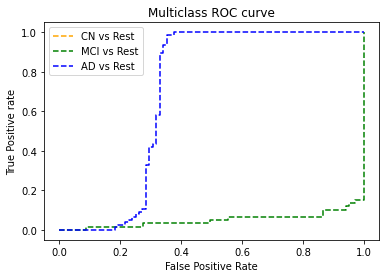

Average AUC: 0.9675368885834322
Log loss: 0.2807134124051933


In [117]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Get class probability scores
predict = ensemble.predict_proba(X_test2)

classes = ['CN', 'MCI', 'AD']

# Get ROC metrics for each class
fpr = {}
tpr = {}
thresh ={}
for i in range(len(classes)):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, predict[:,i], pos_label=i)
    
# Plot the ROC chart
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=classes[0] + ' vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=classes[1] + ' vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=classes[2] + ' vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

auc = roc_auc_score(y_test,predict, multi_class='ovr')
print('Average AUC:', auc)

log_loss = metrics.log_loss(y_test, predict)
print(f"Log loss: {log_loss}")

In [118]:
    hamming_loss = metrics.hamming_loss(y_test, preds)
    jaccard = metrics.jaccard_score(y_test, preds, average='micro')
    
    accuracy = metrics.accuracy_score(y_test, preds)
    #auc_roc=metrics.roc_auc_score(y_test,preds, multi_class='ovr')
    MCC = matthews_corrcoef(y_test, preds) #Matthews correlation coefficient
    
    

    
    print(classification_report(y_test, preds))
    print(f"Hamming Loss: {hamming_loss}")
    print(f"Jaccard Score: {jaccard}")
    print(f"MCC: {MCC}")
    print(f"Accuracy: {accuracy}")
    #print(f"AUC: {auc_roc}")
    print("Overall Accuracy:",accuracy_score(y_test, preds))
    print("Balanced Accuracy:",balanced_accuracy_score(y_test, preds))
    print("Overall Precision:",precision_score(y_test, preds, average='weighted'))
    print("Overall Recall:",recall_score(y_test, preds, average='weighted'))
    print("Overall Precision, Recall, F-measure:",precision_recall_fscore_support(y_test, preds, average='weighted'))
    
    #micro, macro, weighted

              precision    recall  f1-score   support

           1       1.00      0.93      0.96        59
           2       0.88      0.92      0.90        76
           3       0.79      0.79      0.79        29

    accuracy                           0.90       164
   macro avg       0.89      0.88      0.89       164
weighted avg       0.91      0.90      0.90       164

Hamming Loss: 0.0975609756097561
Jaccard Score: 0.8222222222222222
MCC: 0.843973803252585
Accuracy: 0.9024390243902439
Overall Accuracy: 0.9024390243902439
Balanced Accuracy: 0.8821198232284392
Overall Precision: 0.9054878048780488
Overall Recall: 0.9024390243902439
Overall Precision, Recall, F-measure: (0.9054878048780488, 0.9024390243902439, 0.9032619071129983, None)
